# Import

In [1]:
import torch
import cv2
from torchvision import transforms
from PIL import Image

norm = transforms.Normalize( [0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
# imgs = ['test.jpg']
# model = torch.hub.load('hustvl/yolop', 'yolop', pretrained=True)
model = torch.hub.load('ultralytics/yolov5', 'yolov5n', pretrained=True, classes=2)
#inference
timg = cv2.imread('test.jpg')
timg = cv2.cvtColor(timg, cv2.COLOR_BGR2RGB)
timg = cv2.resize(timg,(640,640))/255
timg = torch.Tensor(timg).permute(2,0,1).unsqueeze(0).repeat((2,1,1,1))
result = model(timg.cuda())

Using cache found in /home/admin957/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-3-18 Python-3.11.6 torch-2.2.1 CUDA:0 (NVIDIA GeForce RTX 4090, 24217MiB)

Overriding model.yaml nc=80 with nc=2

                 from  n    params  module                                  arguments                     
  0                -1  1      1760  models.common.Conv                      [3, 16, 6, 2, 2]              
  1                -1  1      4672  models.common.Conv                      [16, 32, 3, 2]                
  2                -1  1      4800  models.common.C3                        [32, 32, 1]                   
  3                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  4                -1  2     29184  models.common.C3                        [64, 64, 2]                   
  5                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  6                -1  3    156928  models.c

In [2]:
ratios = [80, 40, 20]
w, h = 640, 640
def get_coordinate(r,device='cuda'):
    cx = torch.arange(r).repeat(r,1).to(device)
    cy = torch.transpose(cx,0,1)
    return cx, cy

def get_bbox(pred, w, h, r, pretrained=False, device='cuda'):
    tx, ty, tw, th = pred[...,0], pred[...,1], pred[...,2], pred[...,3]
    if not pretrained:
        cx, cy = get_coordinate(r, device)
        bx = torch.sigmoid(tx).mul_(2).sub_(0.5).add_(cx)
        by = torch.sigmoid(ty).mul_(2).sub_(0.5).add_(cy)
        bw = torch.sigmoid(tw).mul_(2).pow_(2)
        bh = torch.sigmoid(th).mul_(2).pow_(2)
        x1, y1 = torch.div(bw,-2).add_(bx).mul_(w), torch.div(bh,-2).add_(by).mul_(h)
        x2, y2 = torch.div(bw,2).add_(bx).mul_(w), torch.div(bh,2).add_(by).mul_(h)
    else:
        cx, cy = tx, ty
        x1, y1 = torch.div(tw,-2).add_(cx), torch.div(th,-2).add_(cy)
        x2, y2 = torch.div(tw,2).add_(cx), torch.div(th,2).add_(cy)
    x1.clip_(0, w), y1.clip_(0, h), x2.clip_(0, w), y2.clip_(0, h)
    bboxes = torch.stack([x1, y1, x2, y2], dim=-1).to(torch.int)
    return bboxes

# bboxes = get_bbox(result[0], w, h, ratios[0])

In [3]:
import torch
import cv2
import torchvision
import os
import json
import numpy as np
import torch.nn as nn
import sys
sys.path.append('/home/admin957/carla/DQLL')
import utils_dqll
import model
from PIL import Image
from utils_dqll import Timer
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import FasterRCNN_MobileNet_V3_Large_320_FPN_Weights
from tqdm import tqdm
import reward
# from ultralytics import YOLO

In [4]:
# yolo = YOLO('yolov8n.pt')

In [5]:
# det_model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT)
# ttttt = torch.hub.load('ultralytics/yolov5', 'yolov5n', pretrained=False)
# det_model.roi_heads.box_predictor.cls_score = nn.Linear(1024, 2, bias=True)
# det_model.roi_heads.box_predictor.bbox_pred = nn.Linear(1024, 2*4, bias=True)

In [6]:
# data_path = '../data/TUSimple/MyTuSimpleLane'
# train_path = os.path.join(data_path,'train')
# test_path = os.path.join(data_path,'test')

In [7]:
# class MyDataset(Dataset):
#     def __init__(self, data_path, transform=None):
#         self.img_dir = os.path.join(data_path,'img')
#         self.bbox_dir = os.path.join(data_path,'bbox')
#         self.img_names = os.listdir(self.img_dir)
#         self.transform = transform
#     def __len__(self):
#         return len(self.img_names)

#     def __getitem__(self, idx):
#         img_path = os.path.join(self.img_dir, self.img_names[idx])
#         json_path = os.path.join(self.bbox_dir, self.img_names[idx].split('.')[0]+'.json')
#         image = self.convert_to_tensor(img_path)
#         with open(json_path) as f:
#             bbox_data = json.load(f)
        
#         bboxes = []
#         labels = []
#         for b in bbox_data:
#             bboxes.append(b['points'])
#             labels.append(b['class'])
#         if self.transform:
#             image = self.transform(image)
#         bboxes = np.array(bboxes)
#         bboxes[:,[0,2]] = bboxes[:,[0,2]] * 0.25
#         bboxes[:,[1,3]] = bboxes[:,[1,3]] * 1/3
#         return image, bboxes, labels

#     def convert_to_tensor(self, path):
#         img = cv2.imread(path)
#         img = cv2.resize(img,(320,240))
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         img = img.astype('float32')
#         input_tensor = img.transpose(2,0,1)
#         input_tensor /= 255
#         return input_tensor

In [8]:
# train_dataset = MyDataset(train_path)
# val_dataset = MyDataset(test_path)

In [7]:
# def my_collate_fn(batch):
#     img_list = np.array([image for image, _, _ in batch])
#     bbox_list = [np.array(bboxes) for _, bboxes, _ in batch]
#     label_list = [labels for _, _, labels in batch]

#     return torch.from_numpy(img_list), bbox_list, label_list

In [8]:
# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=my_collate_fn)
# val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=my_collate_fn)

In [9]:

# def Total_loss(loss):
#     loss_objectness = loss['loss_objectness']
#     loss_rpn_box_reg = loss['loss_rpn_box_reg']
#     loss_classifier = loss['loss_classifier']
#     loss_box_reg = loss['loss_box_reg']
    
#     rpn_total = loss_objectness + 10*loss_rpn_box_reg
#     fast_rcnn_total = loss_classifier + 1*loss_box_reg
    
#     total_loss = rpn_total + fast_rcnn_total
    
#     return total_loss

In [10]:
# optim = torch.optim.Adam(det_model.parameters(), lr=3e-5)

# Train

In [11]:
# a = torch.load('detector2/30.pth')
# for name, child in det_model.named_parameters():
#     child = a[name]
# torch.save(det_model.state_dict(),'detector2/30.pt')

In [ ]:
# savedir = 'detector2'
# os.makedirs(savedir, exist_ok=True)
# det_model.cuda()
# det_model.train()
# epochs = 100
# best_loss = 999999999999999

# for epoch in range(epochs):
#     losses = 0
#     print(f'===== epoch {epoch+1} start =====')
#     for images, bboxes, labels in tqdm(train_loader):
#         images = torch.Tensor(images).cuda()
#         targets = []
#         for i in range(len(images)):
#             d = {}
#             d['boxes'] = torch.Tensor(bboxes[i]).cuda()
#             d['labels'] = torch.LongTensor(labels[i]).cuda()
#             targets.append(d)

#         optim.zero_grad()
#         outputs = det_model(images, targets)
#         loss = Total_loss(outputs)
#         loss.backward()
#         optim.step()
#         losses += loss.cpu().detach().numpy().sum()
#     print(f'train loss : {losses/(len(train_dataset)) :.5f}')
    
#     losses = 0
#     for images, bboxes, labels in tqdm(val_loader):
#         images = torch.Tensor(images).cuda()
#         targets = []
#         for i in range(len(images)):
#             d = {}
#             d['boxes'] = torch.Tensor(bboxes[i]).cuda()
#             d['labels'] = torch.LongTensor(labels[i]).cuda()
#             targets.append(d)

#         optim.zero_grad()
#         outputs = det_model(images, targets)
#         loss = Total_loss(outputs)
#         losses += loss.cpu().detach().numpy().sum()
#     print(f'val loss : {losses/(len(val_dataset)) :.5f}\n')
#     if best_loss > losses:
#         best_loss = losses
#         torch.save(det_model.state_dict(), f'{savedir}/{epoch+1}_{losses/(len(val_dataset)):.5f}.pt')
#         print('-- best model saved --')
#     if epoch %10 == 9:
#         torch.save(det_model.state_dict(), f'{savedir}/{epoch+1}.pt')

# Inference

In [101]:
# det_model.cuda()
# det_model.eval()
# det_model.load_state_dict(torch.load('detector2/50.pt'))

<All keys matched successfully>

In [162]:
# import pickle
# with open('data\\seq_03\\bev_image_label\\bev_image_label_001817820519920.pickle', 'rb') as file:
#     loaded_data = pickle.load(file,encoding='latin1')
# loaded_data.shape
# cv2.imwrite('pickle.jpg',loaded_data)

True

In [39]:
from torchvision import transforms
files = ['test.jpg','track1.jpg','track2.jpg','track3.jpg','track4.jpg','track5.jpg','track6.png','track7.png']
for i,file in enumerate(files):
    norm = transforms.Normalize( [0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    yolo = torch.load('../yolov5/runs/train/s-aug-adam2/weights/epoch25.pt')['model'].cuda().eval()
    timg = cv2.imread(file)
    timg = cv2.cvtColor(timg, cv2.COLOR_BGR2RGB)
    timg = cv2.resize(timg,(640,640))/255
    timg = torch.Tensor(timg).permute(2,0,1).unsqueeze(0).to(torch.half)
    timg = norm(timg)
    result = yolo(timg.cuda())
    # pred = result[0][result[0][...,4]>0.03]
    _, idx = torch.topk(result[0][...,4], 20)
    pred = result[0][:,idx,:].squeeze()
    bboxes = get_bbox(pred, w, h, ratios[0], True)
    bboxes = bboxes.cpu().detach().numpy()
    timg = cv2.imread(file)
    timg = cv2.resize(timg,(640,640))
    for b in bboxes:
        x1,y1,x2,y2 = b
        timg = cv2.rectangle(timg,(x1,y1),(x2,y2),(0,255,0))
    cv2.imwrite(f'track_box{i}.jpg',timg)

In [5]:
import glob

file_paths = glob.glob('test-*.json')
img_path = 'data/TUSimple/MyTuSimpleLane/train/img'
bbox_path = 'data/TUSimple/MyTuSimpleLane/train/bbox'
drl_path = 'data/TUSimple/MyTuSimpleLane/train/DRL/ori'
img_list = os.listdir('data/TUSimple/MyTuSimpleLane/train/img')
img_list = [os.path.join(img_path, tmp)for tmp in img_list]
bbox_list = []
name_list = []
with open('data\TUSimple/train_DRL_list.json','r') as f:
    drl_file_name = json.load(f)
for p in img_list:
    tmp = os.path.basename(p).split('.')[0]
    tmp_bbox = os.path.join(bbox_path, tmp+'.json')
    bbox_list.append(tmp_bbox)
    name_list.append(tmp)
print(img_list[0],drl_file_name[0], len(drl_file_name))
name_list[0]

FileNotFoundError: [Errno 2] No such file or directory: 'data/TUSimple/MyTuSimpleLane/train/img'

[{'class': 1, 'gt': [404, 324, 243, 161, 81]}, {'class': 1, 'gt': [479, 381, 284, 186, 88]}, {'class': 0, 'gt': [75, 175, 276, 377, 477]}, {'class': 0, 'gt': [88, 178, 268, 358, 448]}]


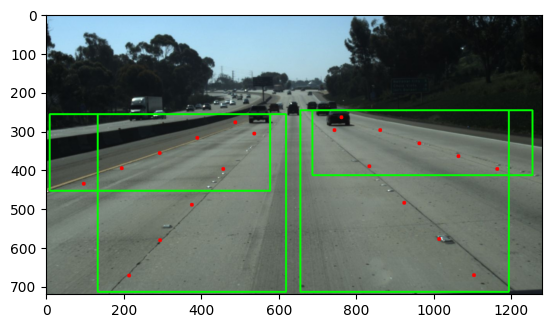

In [86]:
idx = 123
train_img = plt.imread(img_list[idx])
file_name = name_list[idx]
with open(bbox_list[idx],'r') as f:
    bbox_data = json.load(f)
drl_datas = []
for fn in drl_file_name:
    if (file_name in fn):
        tmp_path = os.path.join(drl_path,fn+'.json')
        with open(tmp_path,'r') as f:
            drl_data = json.load(f)
        drl_datas.append(drl_data)
print(drl_datas)
for b,drl in zip(bbox_data,drl_datas):
    x1,y1,x2,y2 = b['points']
    ratio_w, ratio_h = (x2-x1)/100, (y2-y1)/100
    gts = drl['gt']
    cls = drl['class']
    mark = [11, 31, 51, 71, 91]
    gap = (y2-y1)//5
    line_p = [(x1+gts[i],y1+int(mark[i]*ratio_h)) for i in range(len(gts))]
    for p in line_p:
        cv2.line(train_img, p,p, (255,0,0), 9)
    train_img = cv2.rectangle(train_img, (x1,y1),(x2,y2),(0,255,0),3)
plt.imshow(train_img)

(650, 499, 3)
[{'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>)}]
(240, 320, 3)


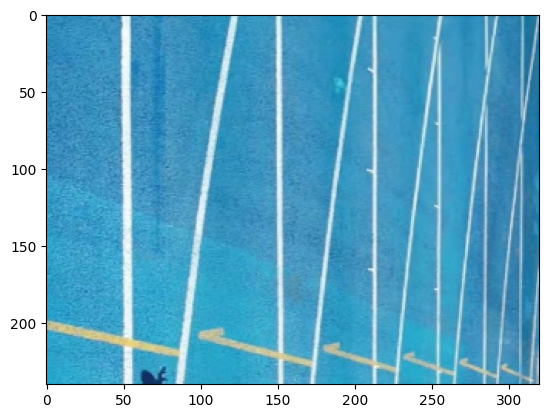

In [102]:
idx = 15

file_name = os.listdir(os.path.join(data_path,'test/img'))[idx]
# img_path = os.path.join(data_path,'test/img',file_name)
img_path = os.path.join('test2.jpg')
# img_path = 'dogs.jpg'
x = np.array(Image.open(img_path))
print(x.shape)
x = cv2.resize(x,(320,240))
# x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
img = torch.Tensor(x.astype('uint8').transpose(2,0,1)).type(torch.uint8)
x = torch.Tensor(x.astype('float32')).permute(2,0,1)
x = [x.cuda()/255]
# x = [torch.rand(3, 300, 400).cuda(), torch.rand(3, 500, 400).cuda()]
predictions = det_model(x)
print(predictions)

import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs, boxes=None):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        img = np.asarray(img)
        if boxes is not None:
            for b in boxes:
                x1,y1,x2,y2 = b
                img = cv2.rectangle(img, (int(x1),int(y1)),(int(x2),int(y2)),(0,255,0),1)
        print(img.shape)
        axs[0, i].imshow(img)
box_np = predictions[0]['boxes'].detach().cpu().numpy()
show(img,box_np)

tensor([[ 70, 109, 215, 193]], device='cuda:0', dtype=torch.int32)
(84, 145, 3)


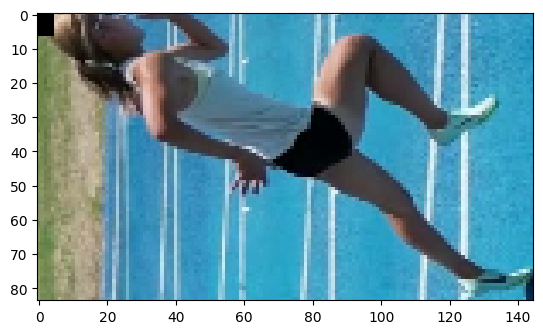

In [93]:
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image

boxes = predictions[0]['boxes']
x1,y1,x2,y2 = boxes[0].detach().cpu().numpy()
labels = predictions[0]['labels']
scores = predictions[0]['scores']
boxes = boxes[scores>0.2].to(torch.int)
nope = torch.Tensor([[0,1,2,3]])
# colors = ["blue", "yellow"]
print(boxes)
result = draw_bounding_boxes(img[:, int(y1):int(y2),int(x1):int(x2)], nope, width=5)
show(result)


In [94]:
meanImg = np.load('C:/Users/zxsxp/Desktop/work/DQLL/data/TuSimple/meanImgTemp.npy')

In [95]:
# extract boxes and resize?
np_img = img.cpu().detach().numpy().transpose(1,2,0)
np_boxes = boxes.cpu().detach().numpy()
np_labels = labels.cpu().detach().numpy()
crop_imgs = []
crop_coords = []
crop_ratios = []

for b in np_boxes:
    x1,y1,x2,y2 = b
    w_ratio, h_ratio = (x2-x1)/100, (y2-y1)/100
    crop = np_img[y1:y2+1, x1:x2+1,:]
    crop = cv2.resize(crop, (100,100))
    crop_imgs.append(crop)
    crop_coords.append((x1,y1))
    crop_ratios.append((w_ratio,h_ratio))

def localization(net, imgs, labels, coords, ratios):
    net.eval()
    steps_cnt = 0
    points = []
    initMarky = [11.0, 31.0, 51.0, 71.0, 91.0]
    for img,label,coord,ratio in zip(imgs,labels,coords,ratios):
        img = img - meanImg
        w_ratio, h_ratio = ratio
        x0, y0 = coord
        if label == 1:
            initMarkX = [91.0, 71.0, 51.0, 31.0, 11.0]
        else:
            initMarkX = [11.0, 31.0, 51.0, 71.0, 91.0]

        for k in np.arange(5, 0, -1):  # 5.4.3.2.1
            cur_x = []
            step = 0
            allActList = np.zeros(10)
            status = 1

            fea_t = np.array(img[(k - 1) * 20:k * 20,:,:])
            fea_t = np.transpose(fea_t, (2, 0, 1))
            fea_t = fea_t.astype(np.float32)
            fea_t = fea_t.reshape((1,fea_t.shape[0],fea_t.shape[1],fea_t.shape[2]))
            fea_t = torch.from_numpy(fea_t).cuda()
            cur_point = initMarkX[k - 1]
            cur_x.append(cur_point)

            hist_vec = np.zeros([32])
            state = reward.get_state(cur_point, hist_vec)
            while (status == 1) & (step < 10):
                step += 1
                state= state.astype(np.float32).reshape((1,-1))
                state = torch.from_numpy(state).cuda()
                qval = np.squeeze(net(fea_t, state).detach().cpu().numpy())
                action = (np.argmax(qval)) + 1
                allActList[step - 1] = action
                if action != 4:
                    if action == 1:
                        cur_point = -20
                    elif action == 2:
                        cur_point -= 5
                    elif action == 3:
                        cur_point += 5
                    cur_x.append(cur_point)
                else:
                    status = 0
                hist_vec = reward.update_history_vector(
                    hist_vec, action)
                state = reward.get_state(cur_point, hist_vec)

            steps_cnt += step
            xpoint = cur_point
            ypoint = initMarky[k - 1]
            xpoint, ypoint = xpoint*w_ratio + x0, ypoint*h_ratio + y0
            points.append((xpoint,ypoint))

    return points
## save points and add box coordinates

net = model.getModel('none').cuda()
net_path = 'exp/24-01-08-23-27_TuSimpleLane/EP_68_HitRat0.89880.pth'
saved_state = torch.load(net_path)
net.load_state_dict(saved_state['weights'])
points = localization(net, crop_imgs, np_labels, crop_coords, crop_ratios)

In [96]:
points

[(85.95, 185.44),
 (114.94999999999999, 168.64),
 (143.95, 151.84),
 (172.95, 135.04),
 (223.7, 118.24)]

In [97]:
np_img.shape

(240, 320, 3)

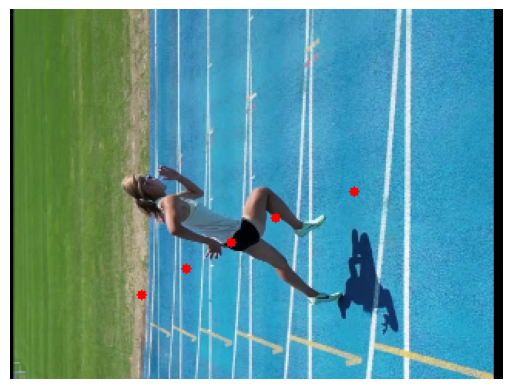

In [98]:
plt.axis('off')
for p in points:
    x,y = p
    x,y = int(x), int(y)
    np_img = cv2.line(np_img,(x,y),(x,y),(255,0,0),5)
plt.imshow(np_img)
plt.show()